# Problem 2 Word2Vec & Seq2Seq Models
---------

## Setup

In [6]:
import os, sys,  json, pickle, tqdm, random, warnings 
from typing import List, Optional

import numpy as np, pandas as pd

import matplotlib as mpl, matplotlib.pyplot as plt#, seaborn as sns

import torch, torch.nn as nn, torch.optim as optim
import pytorch_lightning as pl
from torch.utils import data

from gensim.models import Word2Vec, Phrases
from gensim.test.utils import common_texts
import gensim, gensim.downloader as gensim_api
from gensim import corpora

from gensim.parsing.preprocessing import remove_stopwords, preprocess_documents
from gensim.utils import simple_preprocess

pl.seed_everything(3)

Global seed set to 3


3

### Global Variables

**NOTE**: you can find other `gensim` datasets [here](https://github.com/RaRe-Technologies/gensim-data#datasets)

In [7]:
SAVE_DIR = os.path.abspath('.')

W2V_FILE = os.path.join(SAVE_DIR, 'word2vec.pth')

CORPUS = 'text8'

TXT_FILE = os.path.join(SAVE_DIR, f'{CORPUS}.pkl')

OVERWRITE = False

VEC_SIZE = 50

DEVICE = 'cpu'

SAVE_DIR

'/Users/default/Google Drive/currentDocumants/studies/Master/6.Semester/deep_learning/pset/pset3'

## Part 1

### Fetch you text corpus

**TODO**: generate your own word-vector embedding using a text corpus of _your_ choice of at least **500** words. You may use `gensim`'s corpora.

Feel free to play with hyperparmaters in the notebook such as context size and embedding size.

In [8]:
corpus = gensim_api.load('text8')  # download the corpus and return it opened as an iterable
#length of Dataset corpus
#corpus_vec = [word for _, word in enumerate(corpus)]
#corpus.shape
#len(corpus)
#get type of corpus
#type(corpus)


In [9]:
#does_corpus_exist = os.path.isfile("data/Faust.txt")

#if not does_corpus_exist or OVERWRITE:
#    corpus = gensim_api.load(CORPUS)
#    with open(TXT_FILE, 'wb') as f:
#        pickle.dump(corpus, f)

#else:
#    with open(TXT_FILE, 'rb') as f:
#        corpus = pickle.load(f)

#corpus

### Train your Word2Vec Model

**NOTE**: you are free to create your own Word2Vec model. You are welcome to use `gensim`. However for the pset you must at least _train_ a Word2Vec model!

In [10]:
does_model_exist = os.path.isfile(W2V_FILE)

if not does_model_exist or OVERWRITE:
    w2v = Word2Vec(
        # NOTE: you can use either a list of strings (sentences)
        # or provide a corpus_file
        corpus, 
        
        # Dimensionality of the word vectors.
        vector_size=VEC_SIZE, 
        
        # Maximum distance between the current and predicted word within a sentence.
        window=5, 

        # Ignores all words with total frequency lower than this.
        min_count=30, #1

        # Training algorithm: 1 for skip-gram; otherwise CBOW.
        sg = 1,
        
        # Use these many worker threads to train the model (=faster training 
        # with multicore machines).
        workers=32,

        # If 0, use the sum of the context word vectors. If 1, use the mean, 
        # only applies when cbow is used.
        cbow_mean = 1,

        # Number of iterations (epochs) over the corpus. (Formerly: iter)
        epochs=2 #100
    )

    w2v.add_null_word()

    w2v.save(W2V_FILE)

else:

     w2v = Word2Vec.load(W2V_FILE)

In [28]:
def vec_math(model, *args, return_str_description:bool=False):
    desc = ''
    func = np.add  
    # NOTE: vector_size  
    vect = None
    
    for arg in args:
        if arg == '+':
            desc += ' + '
            func = np.add
        elif arg == '-':
            desc += ' - '
            func = np.subtract
        elif arg == '/':
            desc += ' / '
            func = np.divide
        elif arg == '*':
            desc += ' * '
            func = np.multiply
        else:
            desc += arg
            curr = model.wv[arg]
            if vect is None:
                vect = curr.copy()
            else:
                vect = func(vect, curr)

    if return_str_description:
        return desc, vect

    return vect


In [12]:
# Simple utility function for doing vector math based on a string
#def vec_math(model, *args, return_str_description:bool=False):    
#    desc = ''
#    func = np.add  
    # NOTE: vector_size  
#    vect = None
    
#    for arg in args:
#        match arg:
#            case '+':
#                desc+= ' + '
#                func = np.add

#            case '-':
#                desc+= ' - '
#                func = np.subtract
#                
#            case '/':
#                desc+= ' / '
#                func = np.divide#

#            case '*':
#                desc+= ' * '
#                func = np.multiply

#            case _:
#                desc += arg
#                curr = model.wv[arg]
#                if vect is None:
#                    vect = curr.copy()
#                else:
#                    vect = func(vect, curr)

#    if return_str_description:
#        desc, vect

#    return vect


#### Explore results

NOTE: here my model had 

$$
woman + man - king = girl
$$

and

$$
news + truth - lies = blogging
$$ 

In [13]:
# woman + man - king = ?
gsm_res = w2v.wv.most_similar(positive=['woman','man'], negative=['king'])[0]
gsm_res

('girl', 0.7620220184326172)

In [14]:
# news + truth - lies = ?
gsm_res = w2v.wv.most_similar(positive=['news','truth'], negative=['lies'])[0]
gsm_res

('usenet', 0.7321229577064514)

In [35]:
w2v.wv.most_similar('news')

[('headline', 0.9040331244468689),
 ('overviews', 0.8954185247421265),
 ('cnn', 0.879298210144043),
 ('allafrica', 0.8569325804710388),
 ('blog', 0.8361571431159973),
 ('pbs', 0.8183717727661133),
 ('npr', 0.8139971494674683),
 ('yahoo', 0.8130702376365662),
 ('herald', 0.8103915452957153),
 ('bbc', 0.8064829707145691)]

#### Visualize

**TODO**: Plot these word embeddings (all words) by adjusting the code in the notebook.

You are able to adjust the plotting parameters to suit your needs for making a compelling visualization. 
Discuss what you notice in your embeddings. For example, using the introduction to Charles Darwin's "_On the Origin of Species_" 
as a text file, we obtain the embeddings in Figure 2

/var/folders/yk/dnjthp912l1b5jz35cfdys0r0000gn/T/ipykernel_82613/2146309385.py:23: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(min_vals[0] * lim_scale, max_vals[0] * lim_scale)
/var/folders/yk/dnjthp912l1b5jz35cfdys0r0000gn/T/ipykernel_82613/2146309385.py:24: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(min_vals[1] * lim_scale, max_vals[1] * lim_scale)


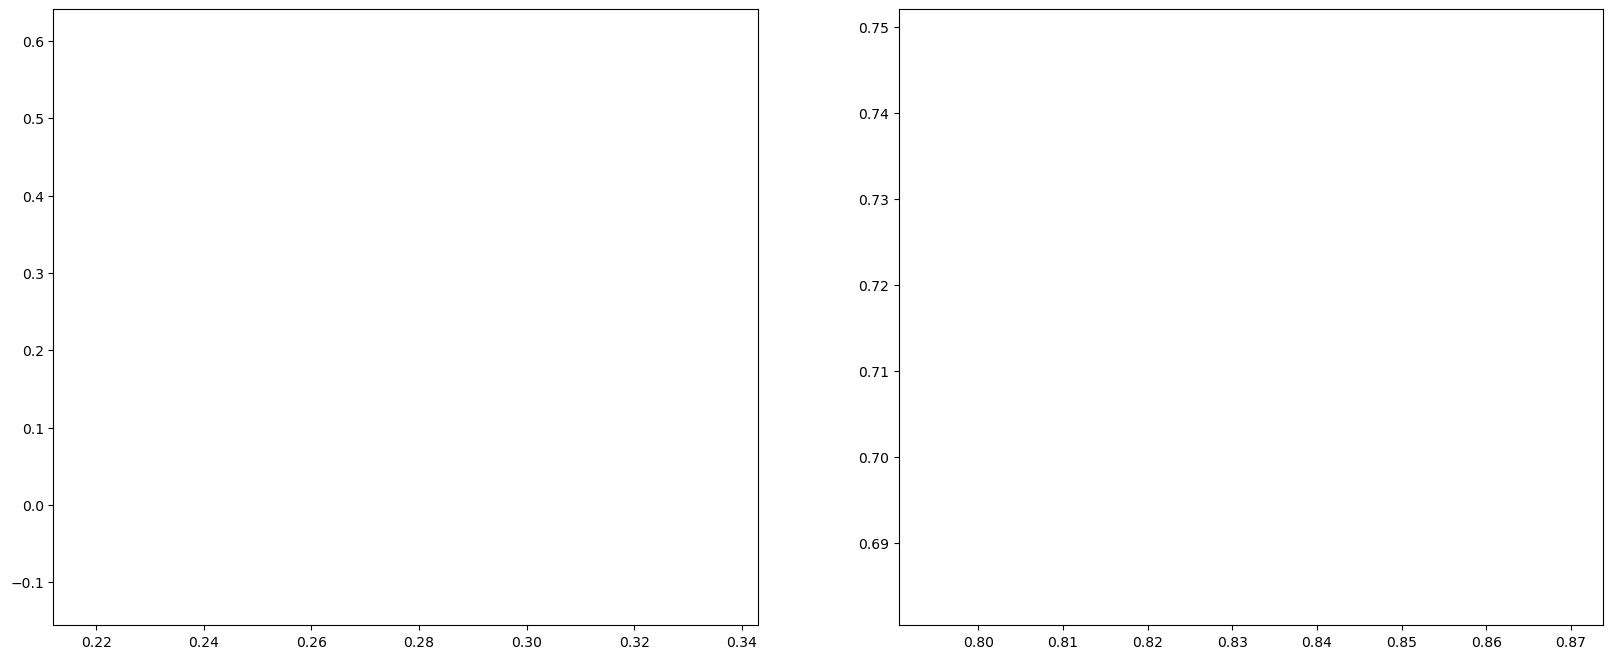

In [29]:
# TODO: modified code from below here
fig = plt.figure(figsize=(20, 8))
lim_scale = 2

word_groups = [
    'originated,abuse'.split(','), 
    'anarchism'.split(','), 
]

for i, words in enumerate(word_groups):
    ax = fig.add_subplot(1, 2, i+1)
    single_words = list(filter(lambda e: e.isalpha(), words))
    domath_words = list(filter(lambda e: not e.isalpha(), words))

    vecs = w2v.wv[single_words]
    for w in domath_words:        
        v = vec_math(w2v, *w.split())
        vecs = np.vstack((vecs, v))      

    min_vals = np.min(vecs, axis=0)
    max_vals = np.max(vecs, axis=0)  

    ax.set_xlim(min_vals[0] * lim_scale, max_vals[0] * lim_scale)
    ax.set_ylim(min_vals[1] * lim_scale, max_vals[1] * lim_scale)

    for j, vec in enumerate(vecs):
        word = words[j]

        plt.scatter(vec[0], vec[1])
        plt.annotate(
            word, xy=(0, 0),  xytext=(vec[0], vec[1]), 
            arrowprops=dict(arrowstyle="<-")
        )

**TODO**: Since this is too crowded to interpret, modify the code in the notebook to randomly select words to plot as long as there is space as shown in Figure 3

KeyError: "Key 'blogging' not present"

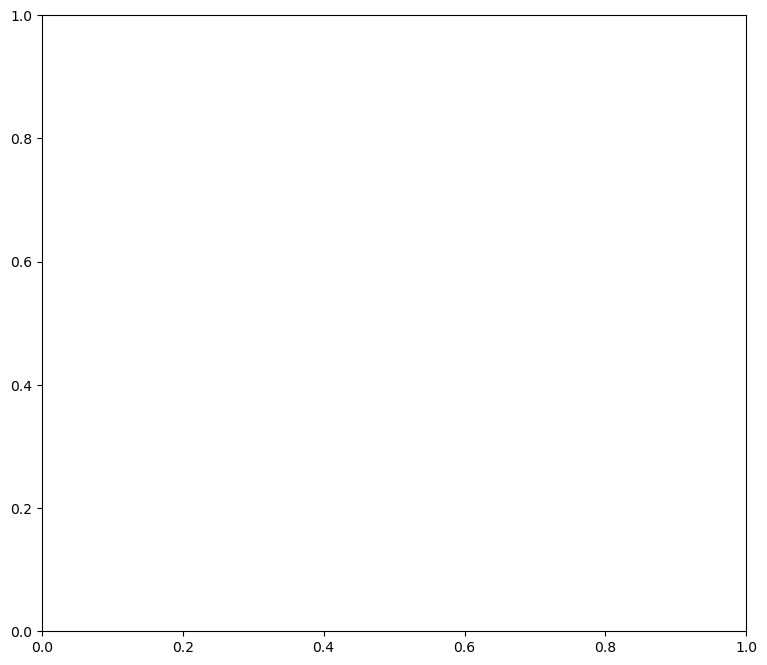

In [16]:
fig = plt.figure(figsize=(20, 8))
lim_scale = 2

word_groups = [
    'computer,news,truth,lies,blogging,news + truth - lies'.split(','), 
    'man,king,woman,queen,woman + man - king'.split(','), 
]

for i, words in enumerate(word_groups):
    ax = fig.add_subplot(1, 2, i+1)
    single_words = list(filter(lambda e: e.isalpha(), words))
    domath_words = list(filter(lambda e: not e.isalpha(), words))

    vecs = w2v.wv[single_words]
    for w in domath_words:        
        v = vec_math(w2v, *w.split())
        vecs = np.vstack((vecs, v))      

    min_vals = np.min(vecs, axis=0)
    max_vals = np.max(vecs, axis=0)  

    ax.set_xlim(min_vals[0] * lim_scale, max_vals[0] * lim_scale)
    ax.set_ylim(min_vals[1] * lim_scale, max_vals[1] * lim_scale)

    for j, vec in enumerate(vecs):
        word = words[j]

        plt.scatter(vec[0], vec[1])
        plt.annotate(
            word, xy=(0, 0),  xytext=(vec[0], vec[1]), 
            arrowprops=dict(arrowstyle="<-")
        )

## Part 2

### Dataset

Whether or not you used `gensim` for training the `Word2Vec` model you will be using PyTorch Lightning for the `Seq2Seq` model. To make this easier on you, you will need to create a `data.Dataset` object which contains, at the very least, `__getitem__` and `__len__` methods to yield items during training. Below is an example which converts a `gensim` corpus paired batches of the first 300 words per doc.

In [ ]:
class Seq2SeqTextDataset(data.Dataset):
    def __init__(self, corpus, keyed_vecs, reverse_target:bool=False):        
        self.corpus = corpus
        self.keyed_vecs = keyed_vecs
        
        docs = self.docs_from_corpus(corpus)
        self.docs = docs
        self.data = docs

        corpora_dct = corpora.Dictionary(docs)
        self.corpora_dct = corpora_dct

        bows = self.bows_from_docs(docs, corpora_dct)
        self.bows = bows
        
        self.reverse_target = reverse_target

    def docs_from_corpus(self, corpus):
        docs = [
            simple_preprocess(remove_stopwords(' '.join(doc)))[:300] 
            for doc in corpus
        ]
        return docs
        
    def bows_from_docs(self, docs, dct):
        return [dct.doc2bow(doc) for doc in docs]


    def __len__(self):        
        return int(len(self.docs))

    def __getitem__(self, idx):
        doc = self.docs[idx]

        source = torch.tensor([self.keyed_vecs.get_index(word) for word in doc])      
        
        target = [self.keyed_vecs.get_index(word) for word in doc]
        if self.reverse_target:
            target = target[::-1]
        target = torch.tensor(target)

        return source, target

### Seq2Seq Model

#### Encoder

**TODO**: fill in the `encode` method

In [ ]:
class Encoder(nn.Module):
    def __init__(
        self, 
        n_vocabsize:int, n_embedding:int, n_hidden:int, n_layers:int, 
        dropout:Optional[float]=0.1, pretrained:Optional[np.ndarray]=None,
    ):
        super(Encoder, self).__init__()
                
        self.n_vocabsize = n_vocabsize
        self.n_embedding = n_embedding
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.dropout = dropout

        embedding = self.make_embedding_layer(n_vocabsize, n_embedding, pretrained)
        self.embedding = embedding

        # NOTE: depending on your dataset you may have to change batch_first
        self.lstm = nn.LSTM(n_embedding, n_hidden, n_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def make_embedding_layer(
        self, 
        n_vocabsize:int, 
        n_embedding:int,
        pretrained:Optional[np.ndarray]=None,
    ):
        if pretrained is not None:
            pretrained = np.array(pretrained)
            n_vocabsize, n_embedding = pretrained.shape
            
            self.n_vocabsize = n_vocabsize
            self.n_embedding = n_embedding

            pretrained = torch.FloatTensor(pretrained) 
            embedding = nn.Embedding.from_pretrained(pretrained)

        else:
            embedding = nn.Embedding(n_vocabsize, n_embedding)

        return embedding
    

    def encode(self, x):
       # TODO: fill this in
       pass
    
    def forward(self, x):
        return self.encode(x)

#### Decoder

**TODO**: fill in the `decode` method

In [ ]:
class Decoder(nn.Module):
    def __init__(
        self,
        n_vocabsize:int, n_embedding:int, n_hidden:int, n_layers:int, 
        dropout:Optional[float]=0.1,
    ):
        super(Decoder, self).__init__()
        self.n_vocabsize = n_vocabsize
        self.n_embedding = n_embedding
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(n_vocabsize, n_embedding)
        self.lstm = nn.LSTM(n_embedding, n_hidden, n_layers, dropout=dropout, batch_first=False)
        self.fc_out = nn.Linear(n_hidden, n_vocabsize)
        self.dropout = nn.Dropout(dropout)

    def decode(self, x, hidden, cell):
        # TODO: fill this in
        pass

    
    def forward(self, x, hidden, cell):
        return self.decode(x, hidden, cell)
    

#### Seq2Seq LightningModule

**TODO**: fill in the `do_seq2seq` method and define the `criterion`

In [ ]:
class Seq2Seq(pl.LightningModule):    
    def __init__(
        self, 
        word_2_vec,
        train_loader,
        n_vocabsize:int=0, 
        n_hidden:int = 2,
        n_layers:int = 2,
        dropout:float = 0.2,
        teacher_forcing_ratio:float=0.5,
        learning_rate:float=0.01,
    ):
                
        super(Seq2Seq, self).__init__()

        self.w2v = word_2_vec
        self.train_loader = train_loader

        n_embedding = word_2_vec.vector_size
        n_vocabsize, n_embedding = np.array(word_2_vec.wv).shape

        self.n_vocabsize = n_vocabsize
        self.n_embedding = n_embedding
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.n_output = n_vocabsize

        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.learning_rate = learning_rate
        
        self.encoder = Encoder(
            n_vocabsize, n_embedding, n_hidden, n_layers, 
            dropout, pretrained=np.array(word_2_vec.wv)
        )
        self.decoder = Decoder(
            n_vocabsize, n_embedding, n_hidden, n_layers, dropout,
        )

        # TODO: self.criterion = loss_fn

    def train_dataloader(self):
        return self.train_loader

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.StepLR(optimizer, 100, gamma=0.99)
        return [optimizer], [scheduler]
    
    def encode(self, word):
        index = self.w2v.wv.get_index(word)
        return torch.tensor(index)
    
    def do_seq2seq(self, source, target):
        # TODO: fill this in
        pass

    def training_step(self, batch, batch_idx):
        x, y = batch
        source = x
        target = y

        output = self.do_seq2seq(source, target)

        # NOTE: this may not be needed depending on your
        output_dim = output.shape[-1]        
        output = output.view(-1, output_dim)
        target = target.view(-1)


        loss = self.criterion(output, target)

        result = {'loss': loss}
        self.log('loss', loss)
        return result

### Instantiate dataset and dataloader 

In [ ]:
ds = Seq2SeqTextDataset(corpus, w2v.wv)

In [ ]:
dl = data.DataLoader(ds, batch_size=3, shuffle=True, drop_last=True)

### Instantiate model

In [ ]:
s2s = Seq2Seq(
    w2v, dl,
    n_hidden=12, n_layers=4, dropout=0.5
).to(DEVICE)
s2s.encoder.to(DEVICE)
s2s.decoder.to(DEVICE)
s2s

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(253854, 50)
    (lstm): LSTM(50, 12, num_layers=4, batch_first=True, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(253854, 50)
    (lstm): LSTM(50, 12, num_layers=4, dropout=0.5)
    (fc_out): Linear(in_features=12, out_features=253854, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (criterion): CrossEntropyLoss()
)

### Define trainer

In [ ]:
trainer = pl.Trainer(
    max_epochs=1,
    
    # NOTE: gradient clipping can help prevent exploding gradients
    gradient_clip_val=100,
    gradient_clip_algorithm='value',    
    log_every_n_steps=5,
    
    # NOTE: this should match your device i.e. if you set cuda above, this should be cuda. 
    # Otherwise it should be cpu. 
    accelerator=DEVICE,    
    
    # NOTE: you can set the maximum time you want to train your model
    max_time={'minutes': 2},    

    # NOTE: setting this to true will save your model every so often
    enable_checkpointing=False,
    accumulate_grad_batches=2
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/solstice/anaconda3/envs/lstm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(


### Train model

**TODO** train your model

In [ ]:
trainer.fit(s2s, dl)


  | Name      | Type             | Params
-----------------------------------------------
0 | encoder   | Encoder          | 12.7 M
1 | decoder   | Decoder          | 16.0 M
2 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
16.0 M    Trainable params
12.7 M    Non-trainable params
28.7 M    Total params
114.797   Total estimated model params size (MB)
/home/solstice/anaconda3/envs/lstm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Time limit reached. Elapsed time is 0:02:25. Signaling Trainer to stop.
`Trainer.fit` stopped: `max_epochs=1` reached.


**TODO**: Train your network also to reconstruct sentences with some words masked. How well does this training perform? Report accuracy at convergence.

### Evaluation

In [ ]:
for source, target in dl:
    break

In [ ]:
res = s2s.do_seq2seq(
    source[0, :].unsqueeze(0),
    target[0, :].unsqueeze(0)
)
res = res.squeeze(1)
res.shape

torch.Size([300, 253854])

In [ ]:
[w2v.wv.index_to_key[idx] for idx in res.argmax(1)]

**TODO**: Put in a sentence from the corpus and write its reconstruction. Is the reconstruction perfect?

**TODO**: Now mask one of the words in the sentence with xxxx and test if it fills the word back.

**TODO**: Finally, start a sentence from the corpus by giving the first 3 words, with the rest of the words masked, see if it completes this sentence.

## Exploration

You can also use `gensim` to load other models aside from `Word2Vec` such as `glove` 

In [ ]:
glove_vectors = gensim_api.load('glove-twitter-25')
glove_vectors.most_similar('twitter')

## Citations

This notebook adapts parts of [@Ben Trevett](https://github.com/bentrevett)'s PyTorch Seq2Seq [notebook](https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb). Additionally we utilize parts of both PyTorch's [documentation](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) as well as [Gensim](https://radimrehurek.com/gensim/intro.html)'s and [Machine Learning Plus](https://www.machinelearningplus.com/)'s [tutorial](https://www.machinelearningplus.com/nlp/gensim-tutorial/)

## Supplementary materials

For those getting started with [`gensim`](https://radimrehurek.com/gensim/intro.html) they may find [Gaurav Padawe](https://medium.com/@grvpdw92) [tutorial](https://medium.com/analytics-vidhya/word2vector-using-gensim-e055d35f1cb4) useful. Of course there is also the official `Word2Vec` `gensim` [tutorial](https://radimrehurek.com/gensim/models/word2vec.html)

For support with [Pylightning](https://lightning.ai/docs/pytorch/stable/) please refer to these documentation pages:
- `Trainer` [documentation](https://lightning.ai/docs/pytorch/stable/common/trainer.html)
- `LightningModule` [documentation](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html)
